# Module 4 - Breast Cancer Analysis 

This notebook is a submission for module 4c.

You can:
    add further cells or text blocks to extend or further explain your solution
    add further functions

Dont:
    rename functions
   

In [3]:
# Fixed dependencies - do not remove or change.
import pytest
import pandas as pd
import numpy as np


# Import your dependencies
import keras.models
import keras.layers 


Using TensorFlow backend.


In [0]:
# Import data

def import_local_data(file_path):
    """This function needs to import the data file into collab and return a pandas dataframe
    """
    return pd.read_excel(file_path)

In [0]:
local_file_path = "https://github.com/agreenhalgh/deep-learning-training/blob/master/breast-cancer.xls?raw=true"

In [0]:
# Dont change
raw_data = import_local_data(local_file_path)

### Conduct exploratory data analysis and explain your key findings

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    286 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  286 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [8]:
raw_data.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,2019-05-03 00:00:00,yes,2,left,right_up,no,recurrence-events


Numerical Features: age (Discrete), tumor-size (Discrete), inv-nodes (Discrete), deg-malig (Discrete) 

Categorical Features: menopause, mode-caps, breast, breast-quad, irradiat, Class

inv-nodes has been corrupted by converting to XLS

In [9]:
raw_data.isnull().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64

There are no null values. Calculate the recurrence rate

In [10]:

recurrence = raw_data['Class'].value_counts()
recurrence['recurrence-events']/recurrence.sum()*100

29.72027972027972

Distribution of recurrence isn't clearly linked with breast.

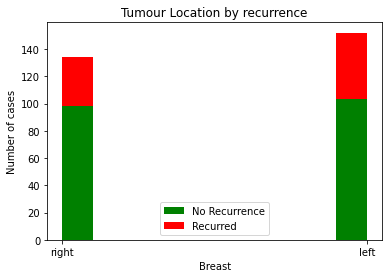

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(x = [raw_data[raw_data['Class']=='no-recurrence-events']['breast'], raw_data[raw_data['Class']=='recurrence-events']['breast']], 
         stacked=True, color = ['g','r'],label = ['No Recurrence','Recurred'])
plt.title('Tumour Location by recurrence')
plt.xlabel('Breast')
plt.ylabel('Number of cases')
plt.legend()

Degree of malignancy is correlated with age, tending to be higher between 30-50, more evenly distributed between 50 and 70, and becoming less after 70.

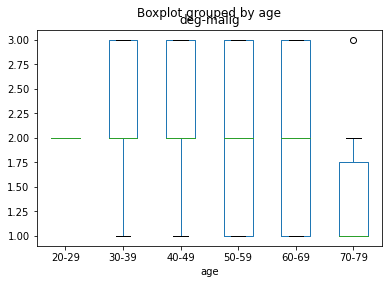

In [14]:
raw_data.boxplot(column='deg-malig', by='age', grid=False )

There are significantly more instances in the left lower and left upper quadrants.

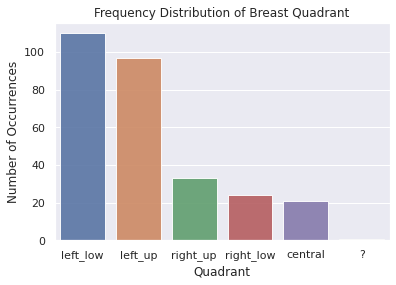

In [18]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
quad_count = raw_data['breast-quad'].value_counts()
sns.barplot(quad_count.index, quad_count.values, alpha=0.9)
plt.title('Frequency Distribution of Breast Quadrant')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Quadrant', fontsize=12)
plt.show()

In [107]:
raw_data['age'].unique()

array(['40-49', '50-59', '60-69', '30-39', '70-79', '20-29'], dtype=object)

The age column is classified into ranges. Take the midpoint of each age as the value. 

In [0]:
raw_data['age'] = raw_data['age'].str.split(pat = '-', n=1, expand=True)
raw_data['age'] = pd.to_numeric(raw_data['age'])+5

inv-nodes, breast, irradiat and Class are all binary

IndexError: ignored

Menopause is another categorical variable. Use one hot encoding to split in to seperate fields

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer 
ct = ColumnTransformer([("Categorize_Menopause", OneHotEncoder(),['menopause'])], remainder="passthrough")
raw_data = ct.fit_transform(raw_data)  

The Class column contains the outcome, which is a binary classification. This will become the `y` dataset. 

In [118]:
raw_data

AttributeError: ignored

In [0]:
# Explain your key findings

Create any data pre-processing that you will conduct on seen and unseen data.  Regardless of the model you use, this dataframe must contain only numeric features and have a strategy for any expected missing values. Any objects can that are needed to handle the test data that are dependent on the training data can be stored in the model class.  You are recommended to use sklearn Pipelines or similar functionality to ensure reproduccibility.

In [0]:
# Split your data so that you can test the effectiveness of your model
                                          random_state=0)

In [0]:
# Populate preprocess_training_data and preprocess_test_data to

In [0]:
class Module4_Model(object):
    
    def __init__(self):
        self.model = None
        
    def preprocess_training_data(self, training_df):
        """
        This function should conduct
        """
        return processed_df

    def preprocess_test_data(self, test_df):

        return processed_df



In [0]:
# Dont change
my_model = Module4_Model()

In [116]:
# Dont change
x_train_processed = my_model.preprocess_training_data(x_train)

NameError: ignored

In [0]:
# Create a model

In [0]:
# Dont change
x_test_processed = my_model.preprocess_test_data(x_test)

In [0]:
# Train your model

In [0]:
# use your model to make a prediction on unseen data

In [0]:
# Asssess the accuracy of your model and explain your key findings